# Statoil/C-CORE Iceberg Classifier Challenge

Identifies if a remotely sensed target is a ship or iceberg.

## Project: Build a Iceberg Classifier using Deep Learning

[Kaggle Statoil Iceberg Classifier Challenge](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge)


---
## Step 1: Import Libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from subprocess import check_output

from matplotlib import pyplot as plt
%matplotlib inline

## Step 2: Load Data

In [2]:
#Change to your directory here
# train.json and test.json are expected in this folder
DATA_PATH = '../data/'
TRAIN_PATH = DATA_PATH + "train.json"
TEST_PATH  = DATA_PATH + "test.json"

In [3]:
test = pd.read_json(TEST_PATH)

In [4]:
train = pd.read_json(TRAIN_PATH)

## Step 3: Display Loaded Data

In [5]:
print("Train Information\n")
train.info()
print("\nTest Information\n")
test.info()

Train Information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 62.7+ KB

Test Information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8424 entries, 0 to 8423
Data columns (total 4 columns):
band_1       8424 non-null object
band_2       8424 non-null object
id           8424 non-null object
inc_angle    8424 non-null float64
dtypes: float64(1), object(3)
memory usage: 263.3+ KB


In [6]:
print("Train Records")
train.head()

Train Records


,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [7]:
print("Test Records")
test.head()

Test Records


,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874


Iceberg::Band-1


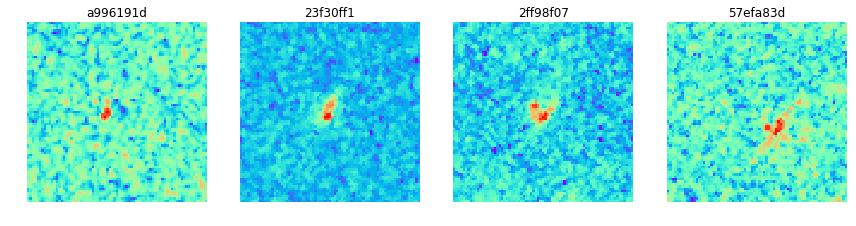

Iceberg::Band-2


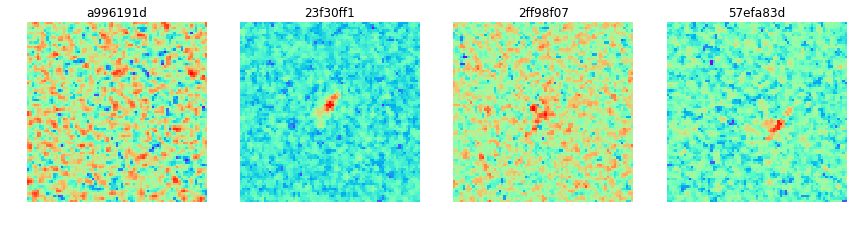

Ship::Band-1


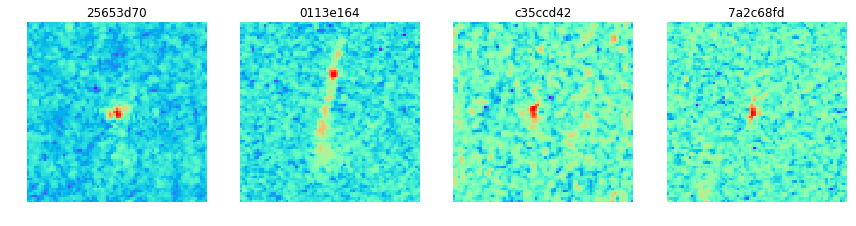

Ship::Band-2


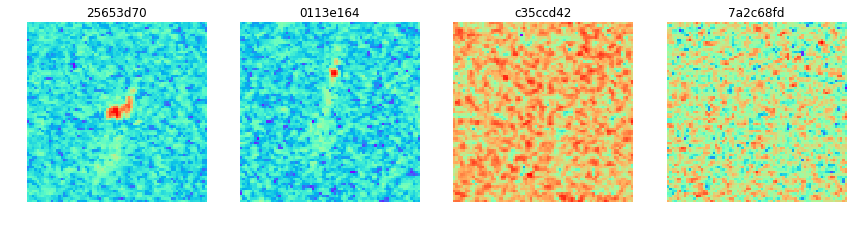

In [8]:
def draw_sample(sample, ncols=4, titles=None):
    nrows = np.ceil(1. * len(sample) / ncols)    
    plt.figure(figsize=(12, 4 * nrows))
    for j, img_raw in enumerate(sample):
        img = np.reshape(img_raw, (75,75))
        plt.subplot(nrows, ncols, j+1)
        plt.imshow(img, cmap='rainbow')
        if titles: plt.title(titles[j])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
sample_icebergs = train[train['is_iceberg'] == 1].sample(4)
sample_ships = train[train['is_iceberg'] == 0].sample(4)
print("Iceberg::Band-1")
draw_sample(sample_icebergs['band_1'], titles=sample_icebergs['id'].tolist())
print("Iceberg::Band-2")
draw_sample(sample_icebergs['band_2'], titles=sample_icebergs['id'].tolist())
print("Ship::Band-1")
draw_sample(sample_ships['band_1'], titles=sample_ships['id'].tolist())
print("Ship::Band-2")
draw_sample(sample_ships['band_2'], titles=sample_ships['id'].tolist())

## Step 4: Fix and Preprocess Data

In [9]:
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)

In [10]:
# Train data
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_train = np.concatenate([x_band1[:, :, :, np.newaxis]
                          , x_band2[:, :, :, np.newaxis]
                         , ((x_band1+x_band1)/2)[:, :, :, np.newaxis]], axis=-1)
X_angle_train = np.array(train.inc_angle)
y_train = np.array(train["is_iceberg"])

# Test data
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([x_band1[:, :, :, np.newaxis]
                          , x_band2[:, :, :, np.newaxis]
                         , ((x_band1+x_band1)/2)[:, :, :, np.newaxis]], axis=-1)
X_angle_test = np.array(test.inc_angle)


X_train, X_valid, X_angle_train, X_angle_valid, y_train, y_valid = train_test_split(X_train
                    , X_angle_train, y_train, random_state=123, test_size=0.33)

## Step 5: Create Model

In [11]:
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
    
def get_model():
    bn_model = 0
    p_activation = "elu"
    input_1 = Input(shape=(75, 75, 3), name="X_1")
    input_2 = Input(shape=[1], name="angle")
    
    img_1 = Conv2D(16, kernel_size = (3,3), activation=p_activation) ((BatchNormalization(momentum=bn_model))(input_1))
    img_1 = Conv2D(16, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = Conv2D(32, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = Conv2D(32, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = Conv2D(64, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = Conv2D(128, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.2)(img_1)
    img_1 = GlobalMaxPooling2D() (img_1)
    
    
    img_2 = Conv2D(128, kernel_size = (3,3), activation=p_activation) ((BatchNormalization(momentum=bn_model))(input_1))
    img_2 = MaxPooling2D((2,2)) (img_2)
    img_2 = Dropout(0.2)(img_2)
    img_2 = GlobalMaxPooling2D() (img_2)
    
    img_concat =  (Concatenate()([img_1, img_2, BatchNormalization(momentum=bn_model)(input_2)]))
    
    dense_ayer = Dropout(0.5) (BatchNormalization(momentum=bn_model) ( Dense(256, activation=p_activation)(img_concat) ))
    dense_ayer = Dropout(0.5) (BatchNormalization(momentum=bn_model) ( Dense(64, activation=p_activation)(dense_ayer) ))
    output = Dense(1, activation="sigmoid")(dense_ayer)
    
    model = Model([input_1,input_2],  output)
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model
model = get_model()
model.summary()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_1 (InputLayer)                (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 75, 75, 3)    12          X_1[0][0]                        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 73, 73, 16)   448         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 71, 71, 16)   2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

## Step 7: Train Model

In [14]:
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

file_path = "../models/model.hdf5"
#callbacks = get_callbacks(filepath=file_path, patience=5)
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', save_best_only=True)
#earlystopping = EarlyStopping(patience=10, monitor='loss')
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=15)


model = get_model()
timeline = model.fit([X_train, X_angle_train], y_train, epochs=64
          , validation_data=([X_valid, X_angle_valid], y_valid)
         #, batch_size=64
         , callbacks=[checkpoint,plateau])

Train on 1074 samples, validate on 530 samples
Epoch 1/64
1074/1074 [==============================] - 24s 22ms/step - loss: 0.6978 - acc: 0.6993 - val_loss: 0.4806 - val_acc: 0.7906
Epoch 2/64
1074/1074 [==============================] - 20s 19ms/step - loss: 0.5286 - acc: 0.7514 - val_loss: 0.3532 - val_acc: 0.8585
Epoch 3/64
1074/1074 [==============================] - 20s 18ms/step - loss: 0.4243 - acc: 0.8156 - val_loss: 0.5173 - val_acc: 0.7811
Epoch 4/64
1074/1074 [==============================] - 20s 19ms/step - loss: 0.3622 - acc: 0.8547 - val_loss: 0.6727 - val_acc: 0.8019
Epoch 5/64
1074/1074 [==============================] - 21s 19ms/step - loss: 0.3539 - acc: 0.8436 - val_loss: 0.3526 - val_acc: 0.8717
Epoch 6/64
1074/1074 [==============================] - 20s 19ms/step - loss: 0.3144 - acc: 0.8752 - val_loss: 0.3322 - val_acc: 0.8736
Epoch 7/64
1074/1074 [==============================] - 20s 18ms/step - loss: 0.3092 - acc: 0.8706 - val_loss: 0.3683 - val_acc: 0.8491
E

1074/1074 [==============================] - 20s 18ms/step - loss: 0.0290 - acc: 0.9926 - val_loss: 0.8589 - val_acc: 0.8472
Epoch 61/64
1074/1074 [==============================] - 20s 19ms/step - loss: 0.0293 - acc: 0.9907 - val_loss: 0.5234 - val_acc: 0.8679
Epoch 62/64
1074/1074 [==============================] - 20s 19ms/step - loss: 0.0373 - acc: 0.9907 - val_loss: 0.4437 - val_acc: 0.8962
Epoch 63/64
1074/1074 [==============================] - 20s 19ms/step - loss: 0.0334 - acc: 0.9898 - val_loss: 0.5383 - val_acc: 0.8811
Epoch 64/64
1074/1074 [==============================] - 20s 19ms/step - loss: 0.0330 - acc: 0.9888 - val_loss: 0.4458 - val_acc: 0.8792


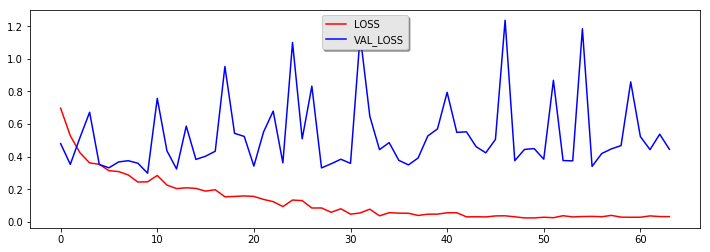

In [15]:
fig, ax = plt.subplots(figsize=(12,4))

plt.plot(timeline.history['loss'], color='red', label='LOSS')
plt.plot(timeline.history['val_loss'], color='blue', label='VAL_LOSS')
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')

## Step 8: Evaluate Model

In [16]:
model.load_weights(filepath=file_path)

print("Evaluate Train Dataset:")
print(model.evaluate([X_train, X_angle_train], y_train, verbose=1, batch_size=200))
print("Evalute Valid Dataset:")
print(model.evaluate([X_valid, X_angle_valid], y_valid, verbose=1, batch_size=200))

Evaluate Train Dataset:
1074/1074 [==============================] - 6s 5ms/step
[0.15387737197416454, 0.93296090162444156]
Evalute Valid Dataset:
530/530 [==============================] - 4s 7ms/step
[0.29932564440763221, 0.8867924382101815]


## Step 9: Predict Model

In [17]:
prediction = model.predict([X_test, X_angle_test], verbose=1, batch_size=200)

8424/8424 [==============================] - 36s 4ms/step


## Step 10: Create submission file

In [18]:
submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})
submission

,id,is_iceberg
0,5941774d,0.019274
1,4023181e,0.003275
2,b20200e4,0.000030
3,e7f018bb,0.990606
4,4371c8c3,0.091970
5,a8d9b1fd,0.078512
6,29e7727e,0.113627
7,92a51ffb,0.998563
8,c769ac97,0.226813
9,aee0547d,0.019076


In [19]:
submission.to_csv("../submission/submission.csv", index=False)